# Performance analysis

Importing libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

MACHINE_ID = {3:'cluster'}
MACHINE_SPEC = {'pc':'Intel Core i7-10750H', 'numa':'spmnuma.unipi.it', 'cluster':'spmcluster.unipi.it'}
LOG_DIR = pathlib.Path('./log_multi_proc')
PLOT_DIR = pathlib.Path('./plots_multi_proc')

BLUE_PALETTE = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#1AC9E6']
PURPLE_PALETTE = ['#30076C', '#7D3AC1', '#AF48CE', '#D36CF2', '#EB549C']
ORANGE_PALETTE = ['#820401', '#C02323', '#DE542C', '#EF7E12' , '#EE9A3A']
GREEN_PALETTE = ['#164B32', '#2E7150', '#44996F', '#6DC296', '#A0E2B6']
PALETTE = [PURPLE_PALETTE, GREEN_PALETTE, ORANGE_PALETTE, BLUE_PALETTE]

METRICS = ['speedup', 'scalability', 'cost', 'efficiency']
PROG_F = ['seq_dm', 'mpi']

DEFAULT_N=2048
STEP_N=512
DEFAULT_DEBUG = 0

NORMAL_FONT = 10
SMALL_FONT = 8

In [2]:
logs = {file.stem:pd.read_csv(file) for file in LOG_DIR.iterdir() if file.is_file()}

Filtering minimum and maximum execution times and computing the mean time:

In [3]:
def trimmed_mean(x):
    if len(x) >= 3:
        return x.drop([x.idxmax(), x.idxmin()]).mean()
    else:
        return x.mean()

for key in logs:
    if 'seq' in key:
        logs[key] = logs[key].groupby(['matrix_size', 'machine_identifier', 'debug_value']).agg(lambda x: trimmed_mean(x))
    elif key  == 'mpi':
        logs[key].drop(['num_workers', 'granularity'], axis=1, inplace=True)
        logs[key] = logs[key].groupby(['matrix_size', 'machine_identifier', 'debug_value', 'num_process']).agg(lambda x: trimmed_mean(x))
    else:
        logs[key] = logs[key].groupby(['matrix_size', 'machine_identifier', 'debug_value', 'num_process', 'num_workers', 'granularity']).agg(lambda x: trimmed_mean(x))

Computing all the metrics to study the parallelization

In [4]:
def compute_metrics(df, seq_df):
    new_df = {'speedup':[], 'efficiency':[], 'cost':[], 'scalability':[]}
    for el in df.iterrows():
        ind = el[0]
        row = el[1]
        
        new_df['speedup'].append(seq_df.loc[ind[:3]]['running_time'] / row['running_time'])
        new_df['efficiency'].append(new_df['speedup'][-1]/ind[3])
        
        new_df['cost'].append(row['running_time'] * ind[3])
        
        new_ind = list(ind)
        new_ind[3] = 1
        new_ind = tuple(new_ind)
        if new_ind  in df.index:
            new_df['scalability'].append(df.loc[new_ind]['running_time'] / row['running_time'])
        else:
            new_df['scalability'].append(-1)
        
    
    return df.assign(**new_df)

for prog_f in PROG_F[1:]:
    if prog_f in logs:
        logs[prog_f] = compute_metrics(logs[prog_f], logs['seq_dm'] )


In [5]:
def fuse_logs(dir_1, dir_2, dir_3):
    log_1 = {file.name:pd.read_csv(file) for file in dir_1.iterdir() if file.is_file()}
    log_2 = {file.name:pd.read_csv(file) for file in dir_2.iterdir() if file.is_file()}
    
    for key in log_1:
        pd.concat([log_1[key], log_2[key]]).to_csv(dir_3 / key, index=False)
        
# fuse_logs(pathlib.Path('./log_tmp_1'), pathlib.Path('./log_tmp_2'), pathlib.Path('./log'))

## GRANULARITY

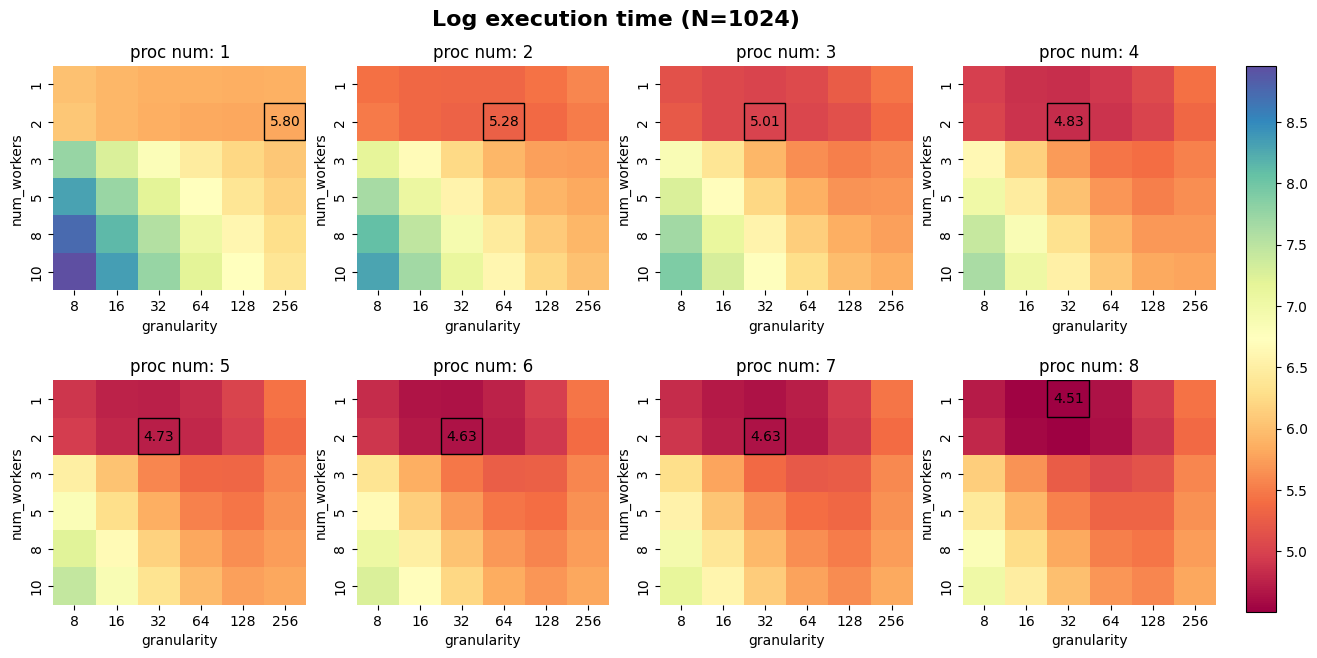

In [6]:
# Creazione di una figura con sottotrame
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # 1 riga, 3 colonne

filename = 'mpi_g_1024'

heatmaps = []
v_min = +np.inf
v_max = -np.inf
for proc_num in range(1,9):
    df = logs[filename].loc[(1024, 3, DEFAULT_DEBUG)].reset_index()
    df.drop(['init_time'], axis=1)
    test = np.log(df.loc[df['num_process'] == proc_num].pivot(index='num_workers', columns='granularity', values='running_time'))
    heatmaps.append(test)
    
    v_min = min(v_min, test.min().min())
    v_max = max(v_max, test.max().max())

for proc_num in range(1,9):
    ax = axes[int((proc_num - 1) / 4), (proc_num - 1) % 4]
    sns.heatmap(heatmaps[proc_num - 1], ax=ax, cmap='Spectral', cbar=False, vmin=v_min, vmax=v_max)
    ax.set_title('proc num: ' + str(proc_num))
    
    # Trova il valore minimo e la sua posizione
    min_value = heatmaps[proc_num - 1].min().min()
    min_position = np.unravel_index(np.argmin(heatmaps[proc_num - 1].values), heatmaps[proc_num - 1].shape)

    # Evidenzia la casella con il valore minimo
    # Le coordinate della casella da evidenziare
    min_row, min_col = min_position

    # Aggiungi un rettangolo attorno alla casella con il valore minimo
    ax.add_patch(plt.Rectangle(
        (min_col, min_row),    # coordinate dell'angolo in basso a sinistra
        0.98, 0.98,                 # larghezza e altezza
        edgecolor='black',       # colore del bordo
        linewidth=1,           # larghezza del bordo
        fill=False             # senza riempimento
    ))
    
    ax.text(
        min_col + 0.5, min_row + 0.5,                # Posizione della annotazione
        f'{min_value:.2f}',                        # Testo dell'annotazione
        color='black',                               # Colore del testo
        ha='center',                               # Allineamento orizzontale
        va='center',                               # Allineamento verticale
        fontsize=10,                               # Dimensione del testo
    )


plt.subplots_adjust(hspace=0.4)  # Modifica 'hspace' per regolare la spaziatura verticale

# Aggiunta di una singola barra di colore sotto tutte le heatmap
cbar_ax = fig.add_axes([0.92, 0.10, 0.02, 0.78])  # [left, bottom, width, height]
norm = plt.Normalize(v_min, v_max)  # Normalizzazione in base ai dati
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=norm)  # Creazione del mappabile
sm.set_array([])  # Imposta un array vuoto perché ScalarMappable richiede un array
fig.colorbar(sm, cax=cbar_ax);  # Aggiunta della colorbar alla figura

fig.suptitle('Log execution time (N=1024)', fontsize=16, fontweight="bold", y=0.96)

plt.savefig(PLOT_DIR / 'granularity_1024.png')

# Display the plot
plt.show()

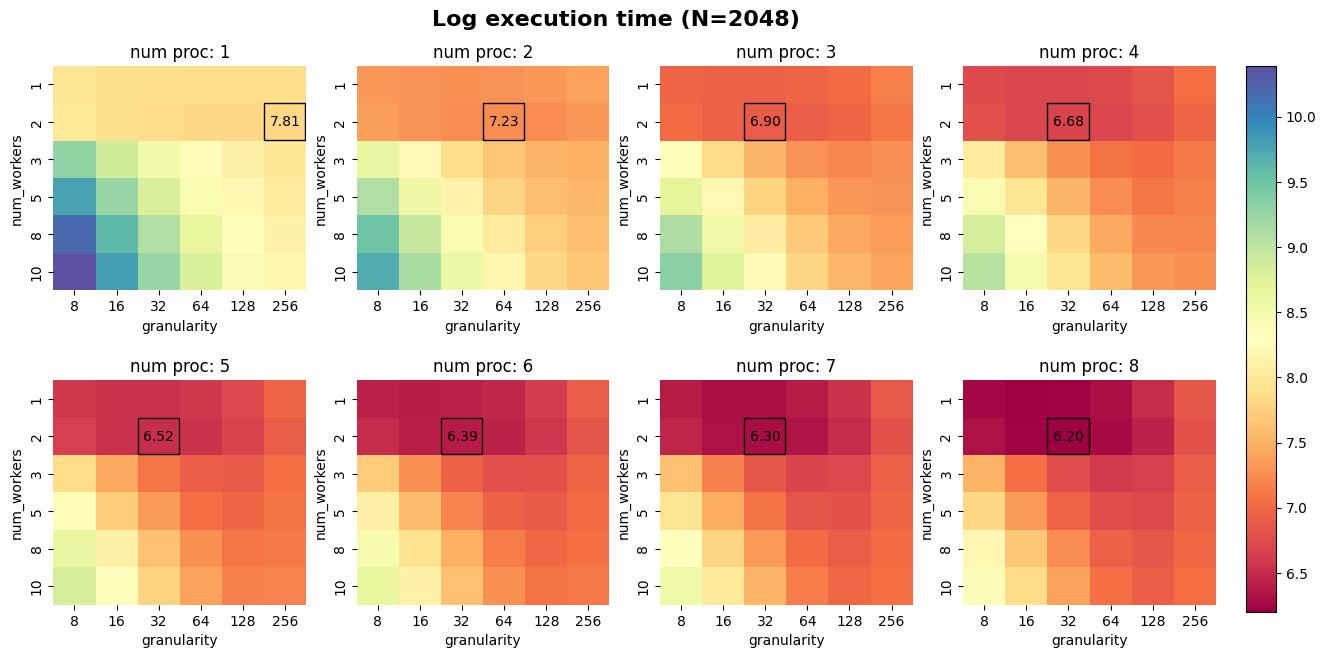

In [7]:
# Creazione di una figura con sottotrame
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # 1 riga, 3 colonne

filename = 'mpi_g_2048'

heatmaps = []
v_min = +np.inf
v_max = -np.inf
for proc_num in range(1,9):

    df = logs[filename].loc[(2048, 3, DEFAULT_DEBUG)].reset_index()
    df.drop(['init_time'], axis=1)
    test = np.log(df.loc[df['num_process'] == proc_num].pivot(index='num_workers', columns='granularity', values='running_time'))
    heatmaps.append(test)
    
    v_min = min(v_min, test.min().min())
    v_max = max(v_max, test.max().max())

for proc_num in range(1,9):
    ax = axes[int((proc_num - 1) / 4), (proc_num - 1) % 4]
    sns.heatmap(heatmaps[proc_num - 1], ax=ax, cmap='Spectral', cbar=False, vmin=v_min, vmax=v_max)
    ax.set_title('num proc: ' + str(proc_num))
    
    # Trova il valore minimo e la sua posizione
    min_value = heatmaps[proc_num - 1].min().min()
    min_position = np.unravel_index(np.argmin(heatmaps[proc_num - 1].values), heatmaps[proc_num - 1].shape)

    # Evidenzia la casella con il valore minimo
    # Le coordinate della casella da evidenziare
    min_row, min_col = min_position

    # Aggiungi un rettangolo attorno alla casella con il valore minimo
    ax.add_patch(plt.Rectangle(
        (min_col, min_row),    # coordinate dell'angolo in basso a sinistra
        0.98, 0.98,                 # larghezza e altezza
        edgecolor='black',       # colore del bordo
        linewidth=1,           # larghezza del bordo
        fill=False             # senza riempimento
    ))
    
    ax.text(
        min_col + 0.5, min_row + 0.5,                # Posizione della annotazione
        f'{min_value:.2f}',                        # Testo dell'annotazione
        color='black',                               # Colore del testo
        ha='center',                               # Allineamento orizzontale
        va='center',                               # Allineamento verticale
        fontsize=10,                               # Dimensione del testo
    )


plt.subplots_adjust(hspace=0.4)  # Modifica 'hspace' per regolare la spaziatura verticale

# Aggiunta di una singola barra di colore sotto tutte le heatmap
cbar_ax = fig.add_axes([0.92, 0.10, 0.02, 0.78])  # [left, bottom, width, height]
norm = plt.Normalize(v_min, v_max)  # Normalizzazione in base ai dati
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=norm)  # Creazione del mappabile
sm.set_array([])  # Imposta un array vuoto perché ScalarMappable richiede un array
fig.colorbar(sm, cax=cbar_ax);  # Aggiunta della colorbar alla figura

fig.suptitle('Log execution time (N=2048)', fontsize=16, fontweight="bold", y=0.96)

plt.savefig(PLOT_DIR / 'granularity_2048.png')

# Display the plot
plt.show()

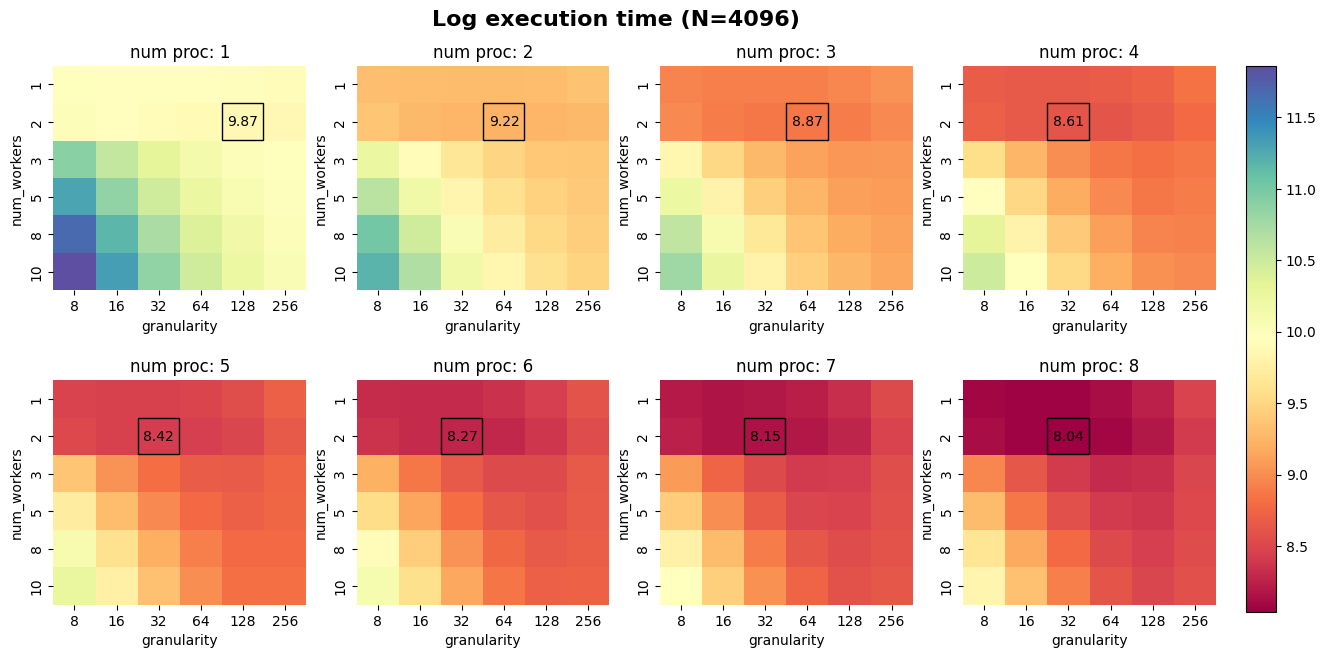

In [8]:
# Creazione di una figura con sottotrame
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # 1 riga, 3 colonne

filename = 'mpi_g_4096'

heatmaps = []
v_min = +np.inf
v_max = -np.inf
for proc_num in range(1,9):

    df = logs[filename].loc[(4096, 3, DEFAULT_DEBUG)].reset_index()
    df.drop(['init_time'], axis=1)
    test = np.log(df.loc[df['num_process'] == proc_num].pivot(index='num_workers', columns='granularity', values='running_time'))
    heatmaps.append(test)
    
    v_min = min(v_min, test.min().min())
    v_max = max(v_max, test.max().max())

for proc_num in range(1,9):
    ax = axes[int((proc_num - 1) / 4), (proc_num - 1) % 4]
    sns.heatmap(heatmaps[proc_num - 1], ax=ax, cmap='Spectral', cbar=False, vmin=v_min, vmax=v_max)
    ax.set_title('num proc: ' + str(proc_num))
    
    # Trova il valore minimo e la sua posizione
    min_value = heatmaps[proc_num - 1].min().min()
    min_position = np.unravel_index(np.argmin(heatmaps[proc_num - 1].values), heatmaps[proc_num - 1].shape)

    # Evidenzia la casella con il valore minimo
    # Le coordinate della casella da evidenziare
    min_row, min_col = min_position

    # Aggiungi un rettangolo attorno alla casella con il valore minimo
    ax.add_patch(plt.Rectangle(
        (min_col, min_row),    # coordinate dell'angolo in basso a sinistra
        0.98, 0.98,                 # larghezza e altezza
        edgecolor='black',       # colore del bordo
        linewidth=1,           # larghezza del bordo
        fill=False             # senza riempimento
    ))
    
    ax.text(
        min_col + 0.5, min_row + 0.5,                # Posizione della annotazione
        f'{min_value:.2f}',                        # Testo dell'annotazione
        color='black',                               # Colore del testo
        ha='center',                               # Allineamento orizzontale
        va='center',                               # Allineamento verticale
        fontsize=10,                               # Dimensione del testo
    )


plt.subplots_adjust(hspace=0.4)  # Modifica 'hspace' per regolare la spaziatura verticale

# Aggiunta di una singola barra di colore sotto tutte le heatmap
cbar_ax = fig.add_axes([0.92, 0.10, 0.02, 0.78])  # [left, bottom, width, height]
norm = plt.Normalize(v_min, v_max)  # Normalizzazione in base ai dati
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=norm)  # Creazione del mappabile
sm.set_array([])  # Imposta un array vuoto perché ScalarMappable richiede un array
fig.colorbar(sm, cax=cbar_ax);  # Aggiunta della colorbar alla figura

fig.suptitle('Log execution time (N=4096)', fontsize=16, fontweight="bold", y=0.96)

plt.savefig(PLOT_DIR / 'granularity_4096.png')

# Display the plot
plt.show()


## Strong Scalability

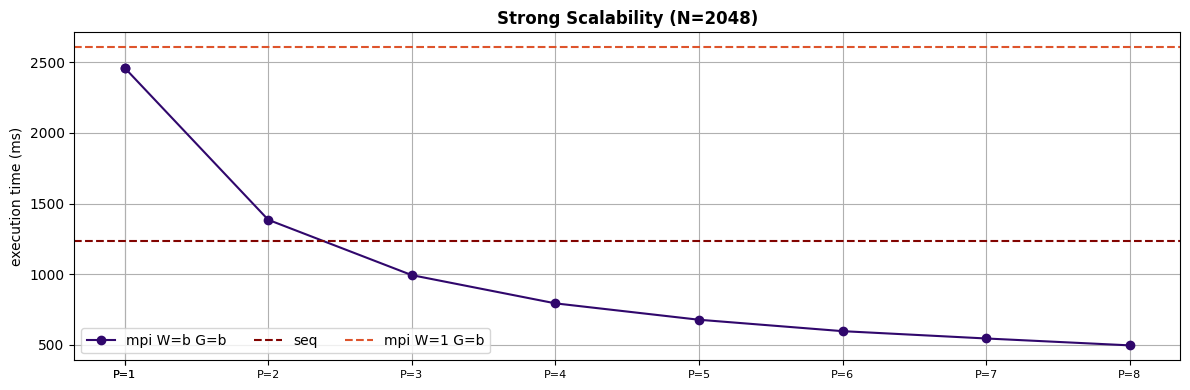

In [9]:

# Creating the figure and subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Define x-values for the plot
xvalues = [1] + [x for x in range(1, 9, 1)]

# Iterate over MACHINE_ID, MAT_F, and PROG_F
for i, key in enumerate(MACHINE_ID):
    for k, prog_f in enumerate(PROG_F[1:]):
        filename = prog_f
        ind = [(DEFAULT_N, key, DEFAULT_DEBUG, x) for x in xvalues]
        ax.plot(
            logs[filename].loc[ind].reset_index()['num_process'].values,
            logs[filename].loc[ind].reset_index()['running_time'].values,
            '-o',
            label=f'{prog_f} W=b G=b',
            color=PALETTE[i][k]
        )

# Plot sequential baseline for each MACHINE_ID and MAT_F
for i, key in enumerate(MACHINE_ID):
    filename = 'seq_dm'
    ind = [(DEFAULT_N, key, DEFAULT_DEBUG)]
    ax.axhline(
        y=logs[filename].loc[ind].reset_index()['running_time'].values,
        color=ORANGE_PALETTE[0],
        linestyle='--',
        label=f'seq'
    )
ax.axhline(
        y=2607.863,
        color=ORANGE_PALETTE[2],
        linestyle='--',
        label=f'mpi W=1 G=b'
    )

# Set x-axis ticks and labels
labels = [f'P={y}' for y in xvalues]
ax.set_xticks(xvalues)
ax.set_xticklabels(labels, fontsize=SMALL_FONT)

# Set y-axis label and legend
ax.set_ylabel("execution time (ms)")
ax.legend(fontsize=NORMAL_FONT, ncol=3)

# Set y-axis scale to logarithmic, add grid, and set title
# ax.set_yscale('log')
ax.grid()
ax.set_title(
    f'Strong Scalability (N={DEFAULT_N})',
    fontweight="bold"
)

# Adjust layout
plt.tight_layout()
plt.savefig(PLOT_DIR / 'strong_scalability.png')

# Display the plot
plt.show()


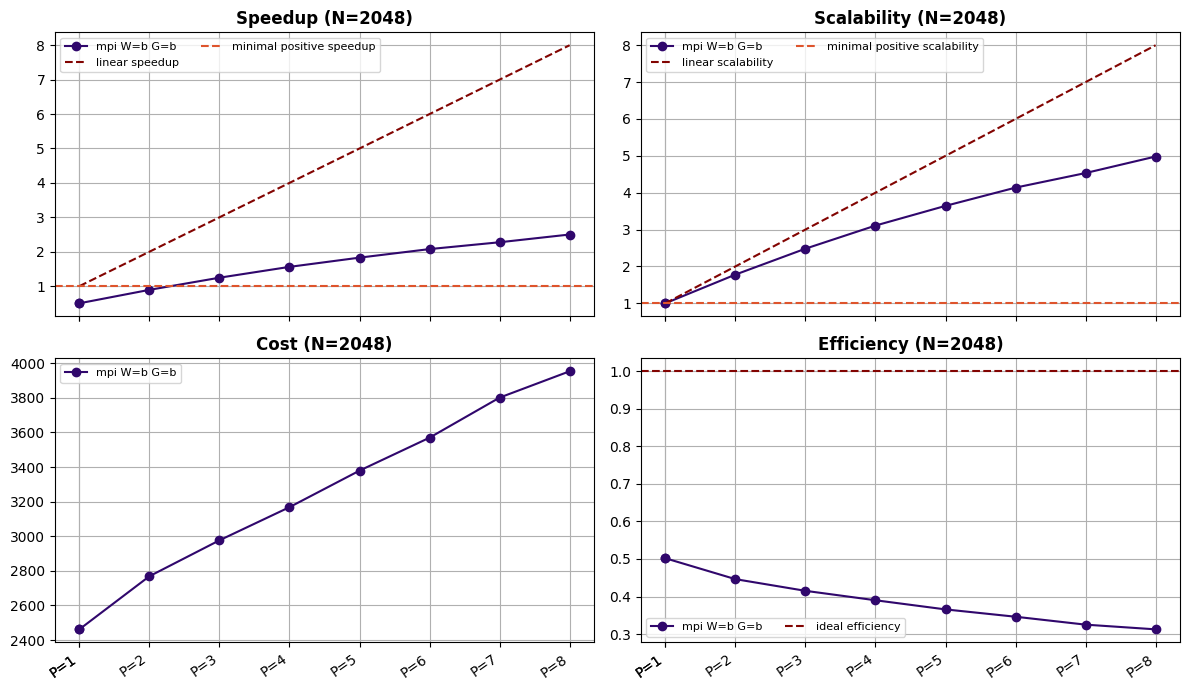

In [10]:
# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# Define x-values for the plot
xvalues = [1] + [x for x in range(1, 9, 1)]

# Iterate over metrics to plot
for j, col in enumerate(METRICS):
    ax = axs[int(j / 2), j % 2]
    
    # Plot data for each MACHINE_ID, MAT_F, and PROG_F combination
    for i, key in enumerate(MACHINE_ID):
        for k, prog_f in enumerate(PROG_F[1:]):
            filename = prog_f
            ind = [(DEFAULT_N, key, DEFAULT_DEBUG, x) for x in xvalues]
            ax.plot(
                logs[filename].loc[ind].reset_index()['num_process'].values,
                logs[filename].loc[ind].reset_index()[col].values,
                '-o',
                label=f'{prog_f} W=b G=b',
                color=PALETTE[i][k]
            )
    
    # Set title and x-axis ticks/labels
    ax.set_title(f'{col.capitalize()} (N={DEFAULT_N})', fontweight="bold")
    ax.set_xticks(xvalues)
    
    # Adjust x-axis labels for readability
    if j >= 2:
        labels = [f'P={y}' for y in xvalues]
        ax.set_xticklabels(labels, fontsize=10, rotation=35)
        for label in ax.get_xticklabels():
            label.set_horizontalalignment('right')
    else:
        ax.set_xticklabels([])
    
    # Add annotations for specific lines
    if j == 0:
        ax.plot(ax.get_xticks(), ax.get_xticks(),
                '--', label='linear speedup', color=ORANGE_PALETTE[0])
        ax.axhline(y=1, label='minimal positive speedup', linestyle='--', color=ORANGE_PALETTE[2])
    elif j == 1:
        ax.plot(ax.get_xticks(), ax.get_xticks(),
                '--', label='linear scalability', color=ORANGE_PALETTE[0])
        ax.axhline(y=1, label='minimal positive scalability', linestyle='--', color=ORANGE_PALETTE[2])
    elif j == 3:
        ax.axhline(y=1, label='ideal efficiency', linestyle='--', color=ORANGE_PALETTE[0])
    
    # Set plot configurations
    ax.legend(fontsize=SMALL_FONT, ncol=2)
    ax.grid()
    # ax.set_yscale('log')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(PLOT_DIR / 'strong_scalability_metrics.png')
plt.show()


## Weak Scalability - quadratic increase

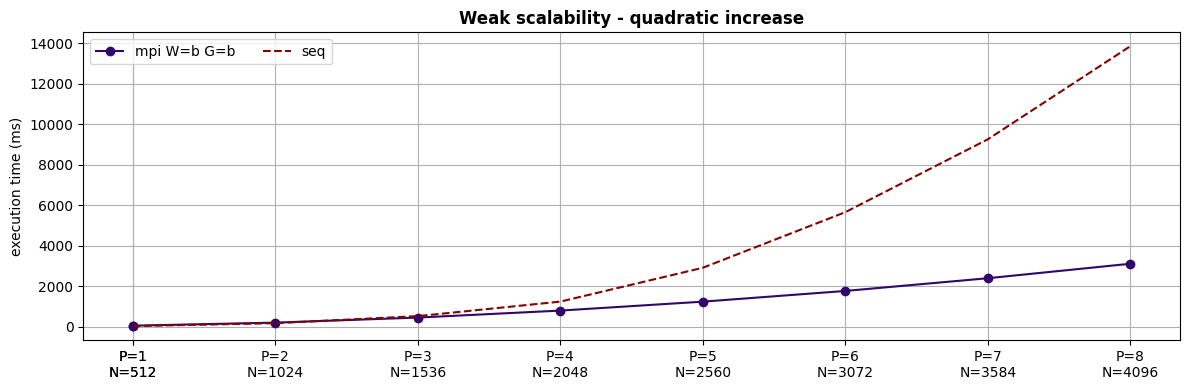

In [11]:
# Creazione della figura e dei sottotrame
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

xvalues = [1] + [x for x in range(1,9,1)]

for i, key in enumerate(MACHINE_ID): 
    for k, prog_f in enumerate(PROG_F[1:]):
        filename = prog_f
        ind = [(STEP_N * x, key, DEFAULT_DEBUG, x) for x in xvalues]
        ax.plot(logs[filename].loc[ind].reset_index()['num_process'].values,
                logs[filename].loc[ind].reset_index()['running_time'].values, 
                '-o',
                label=f'{prog_f} W=b G=b',
                color=PALETTE[i][k])
            
for i, key in enumerate(MACHINE_ID):
    filename = 'seq_dm'
    ind = [(STEP_N*x, key, DEFAULT_DEBUG) for x in  xvalues]
    ax.plot(xvalues,
                logs[filename].loc[ind].reset_index()['running_time'].values, 
                '--',
                label=f'seq',
                color=ORANGE_PALETTE[0])
        
labels = [f'P={y}\nN={STEP_N * y}' for y in xvalues] 
ax.set_xticks(xvalues)
ax.set_xticklabels(labels, fontsize=NORMAL_FONT)

ax.set_ylabel("execution time (ms)")
ax.legend(fontsize=NORMAL_FONT, ncol=3)
#ax.set_yscale('log')
ax.grid()
ax.set_title(
    f'Weak scalability - quadratic increase',
    fontweight="bold"
)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'quadratic_weak_scalability.png')

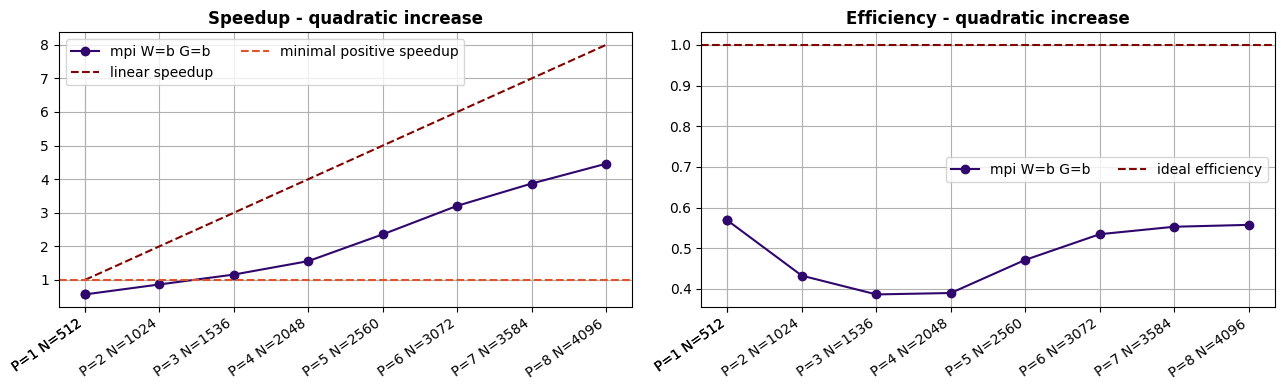

In [12]:
# Creazione della figura e dei sottotrame
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

xvalues = [1] + [x for x in range(1,9,1)]
for j, col in enumerate(METRICS[:1] + METRICS[-1:]):
    ax = axs[j]
    for i, key in enumerate(MACHINE_ID):
            for k, prog_f in enumerate(PROG_F[1:]):
                filename = prog_f
                ind = [(STEP_N * x, key, DEFAULT_DEBUG, x) for x in xvalues]
                ax.plot(logs[filename].loc[ind].reset_index()['num_process'].values,
                        logs[filename].loc[ind].reset_index()[col].values, 
                        '-o',
                        label=f'{prog_f} W=b G=b',
                        color=PALETTE[i][k])
                
    ax.set_title(
        f'{col.capitalize()} - quadratic increase',
        fontweight="bold"
    )
    
    ax.set_xticks(xvalues)

    labels = [f'P={y} N={STEP_N*y}' for y in xvalues] 
    ax.set_xticklabels(labels, fontsize=NORMAL_FONT, rotation=35)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

        
axs[0].plot(axs[0].get_xticks(), axs[0].get_xticks(), 
                    '--',
                    label=f'linear speedup',
                    color=ORANGE_PALETTE[0])

axs[0].axhline(y=1,
                label=f'minimal positive speedup',
                 linestyle='--',
                color=ORANGE_PALETTE[2])
axs[1].axhline(y=1,
                label=f'ideal efficiency',
                 linestyle='--',
                color=ORANGE_PALETTE[0])

for l in range(2):
    ax = axs[l]
    ax.legend(fontsize=NORMAL_FONT, ncol=2)
    ax.grid()
    # ax.set_yscale('log')
    
plt.tight_layout()
plt.savefig(PLOT_DIR / 'quadratic_weak_scalability_metrics.png')